In [1]:
import sys
sys.path.append('../..')
from model import processing
from model.amm.money_market import MoneyMarket, MoneyMarketAsset, CDP
from model.amm.trade_strategies import liquidate_cdps
mm = processing.get_current_money_market()
original_cdps = mm.cdps
print(mm)

Pool Address: 0x1b02E051683b5cfaC5929C25E84adb26ECf87B38
money_market(    liquidity: {'USDC': 488650132873, 'USDT': 463500342036, 'WBTC': 1190534949, 'DOT': 9746203496745822, 'vDOT': 2977259762805617, 'tBTC': 10000720295006823897, '2-Pool-GDOT': 2222173552478671910180927}
    liquidation threshold: {('USDC', 'USDT'): 0.93, ('USDC', 'WBTC'): 0.9, ('USDC', 'DOT'): 0.9, ('USDC', 'vDOT'): 0.9, ('USDC', 'tBTC'): 0.9, ('USDC', '2-Pool-GDOT'): 0.9, ('USDT', 'USDC'): 0.93, ('USDT', 'WBTC'): 0.9, ('USDT', 'DOT'): 0.9, ('USDT', 'vDOT'): 0.9, ('USDT', 'tBTC'): 0.9, ('USDT', '2-Pool-GDOT'): 0.9, ('WBTC', 'USDC'): 0.7, ('WBTC', 'USDT'): 0.7, ('WBTC', 'DOT'): 0.7, ('WBTC', 'vDOT'): 0.7, ('WBTC', 'tBTC'): 0.7, ('WBTC', '2-Pool-GDOT'): 0.7, ('DOT', 'USDC'): 0.8, ('DOT', 'USDT'): 0.8, ('DOT', 'WBTC'): 0.8, ('DOT', 'vDOT'): 0.9, ('DOT', 'tBTC'): 0.8, ('DOT', '2-Pool-GDOT'): 0.8, ('vDOT', 'USDC'): 0.7, ('vDOT', 'USDT'): 0.7, ('vDOT', 'WBTC'): 0.7, ('vDOT', 'DOT'): 0.9, ('vDOT', 'tBTC'): 0.7, ('vDOT', '2-

In [36]:
omnipool_router = processing.get_current_omnipool_router()
# print(omnipool_router)
print('Got Omnipool data...')

Got Omnipool data...


In [48]:
from model.amm.omnipool_amm import OmnipoolState
from model.amm.stableswap_amm import StableSwapPoolState

omnipool = omnipool_router.exchanges['omnipool']
omnipool_copy = omnipool.copy()
lrna_price = mm.price('DOT') / omnipool.lrna_price('DOT')
# lrna_price_2 = mm.price('vDOT') / omnipool.lrna_price('vDOT')
# print(lrna_price_1, lrna_price_2)
# lrna_price = (lrna_price_1 + lrna_price_2) / 2

for exchange in [exchange for exchange in omnipool_router.exchanges.values() if isinstance(exchange, StableSwapPoolState)]:
    priced_assets = list(filter(lambda x: x, [tkn[:-2] if tkn[:-2] in mm.prices else (tkn[1:] if tkn[1:] in mm.prices else '') for tkn in exchange.asset_list]))
    print(priced_assets)
    pool_price = sum(mm.price(tkn) for tkn in priced_assets) / len(priced_assets)
    print(f"Average price of assets in {exchange.unique_id} is {pool_price}.")
    # print(exchange, '\n')
    for tkn in exchange.asset_list:
        tkn_name = tkn[:-2] if tkn[-2:].isdigit() else (tkn[1:] if tkn[1:] in mm.prices else tkn)
        print(tkn)
        tkn_price = pool_price
        new_liquidity = exchange.liquidity[tkn]
        if not new_liquidity:
            new_liquidity = exchange.shares / 10 ** 18 * mm.price(tkn_name) / pool_price / len(exchange.asset_list)
        new_lrna = new_liquidity * tkn_price / lrna_price
        new_shares = new_liquidity
        if tkn_name not in omnipool.asset_list:
            omnipool.add_token(
                tkn=tkn_name,
                liquidity=new_liquidity,
                lrna=new_lrna,
                shares=new_shares,
                protocol_shares=new_shares
            )
        else:
            omnipool.liquidity[tkn_name] += new_liquidity
            omnipool.lrna[tkn_name] += new_lrna
            omnipool.shares[tkn_name] += new_shares
            omnipool.protocol_shares[tkn_name] += new_shares

gigadot_liquidity = omnipool_router.exchanges['stableswap03'].shares / 10 ** 18
omnipool=omnipool.add_token(
    tkn='2-Pool-GDOT',
    liquidity=gigadot_liquidity,
    lrna=gigadot_liquidity * pool_price / lrna_price,
    shares=gigadot_liquidity,
)
            
# print(omnipool)
# print(omnipool.sub_pools)

['USDT', 'USDC', 'USDT']
Average price of assets in 4-Pool is 0.9995503566666667.
USDT10
DAI
USDC21
USDT23
['WBTC']
Average price of assets in 2-Pool101 is 86804.32311527.
iBTC11
WBTC19
['USDT', 'USDC']
Average price of assets in 2-Pool102 is 0.999641495.
USDT10
USDC22
['vDOT', 'DOT']
Average price of assets in stableswap03 is 4.77045053.
vDOT15
aDOT


In [49]:
omnipool.liquidity

{'4-Pool': 1137848.9630020165,
 'KSM': 35231.97769698111,
 'HDX': 74149461.94812712,
 'KILT': 4167610.3623772818,
 'WETH': 527.6561184249824,
 '2-Pool101': 0.4224420856162169,
 'GLMR': 17155326.492577937,
 'iBTC11': 9.24812437,
 'BNC': 6974576.313474764,
 'WBTC19': 8.99577619,
 'RING': 36119363.86872171,
 'vASTR': 10762252.31962968,
 'vDOT15': 604568.762031174,
 'CFG': 5368000.142709429,
 'CRU': 521616.6905339749,
 '2-Pool102': 15257208.690709686,
 'DOT': 8324985.033461102,
 'AAVE': 5101.583573180738,
 'PHA': 6773659.711982299,
 'tBTC': 48.44223015683604,
 'ZTG': 8666574.926743273,
 'INTR': 76065091.7278327,
 'ASTR': 60075621.02514951,
 'SOL': 697.780945753,
 'USDT': 55658059.460664004,
 'DAI': 1616133.4132404465,
 'USDC': 54381082.704144,
 'iBTC': 1.3735696800000001,
 'WBTC': 1.3703103,
 'vDOT': 7995231.5211401265,
 '2-Pool-GDOT': 2222194.6822020775}

In [50]:
mm.prices

{'USDC': 0.99991491,
 'USDT': 0.99936808,
 'WBTC': 86804.32311527,
 'DOT': 3.81970169,
 'vDOT': 5.72119937,
 'tBTC': 86863.43902701,
 '2-Pool-GDOT': 3.82762459,
 'HDX': 0.012368833008014054}

In [51]:
# replace DOT collateral with HDX
hdx = MoneyMarketAsset(
    name='HDX',
    price=omnipool.usd_price('HDX', 'USDT'),
    liquidity=10000000,
    liquidation_bonus=0.10,
    liquidation_threshold=0.7,
    ltv=0.6
)
mm.add_new_asset(hdx)
# mm.prices = {tkn: omnipool.usd_price(tkn, 'USDT') for tkn in mm.prices}
# distribution = processing.distribute_value(
#     num_positions=50,
#     total_value=1000000,
#     concentration=0.8
# )

price_ratio = mm.price('DOT') / mm.price('HDX')
hdx_cdps = []
for cdp in [cdp for cdp in original_cdps if cdp.health_factor > 0]:
    if 'DOT' in cdp.collateral:
        hdx_collateral = cdp.collateral['DOT'] * price_ratio * 8 / 7
        other_collateral = {tkn: cdp.collateral[tkn] for tkn in cdp.collateral if tkn != 'DOT'}
        debt_value = sum([cdp.debt[tkn] * mm.prices[tkn] for tkn in cdp.debt])
        new_cdp = CDP(
            collateral={'HDX': hdx_collateral, **other_collateral},
            debt={'USDT': debt_value / mm.prices['USDT']}
        )
        precision = 20
        new_cdp.health_factor = mm.get_health_factor(new_cdp)
        if abs(cdp.health_factor - new_cdp.health_factor) / cdp.health_factor > 2 ** -precision:
            for i in range(precision):
                # print(f"target: {cdp.health_factor}, value: {new_cdp.health_factor}")
                if mm.get_health_factor(new_cdp) < cdp.health_factor:
                    new_cdp.collateral['HDX'] += hdx_collateral * 2 ** -i
                else:
                    new_cdp.collateral['HDX'] -= hdx_collateral * 2 ** -i
                new_cdp.health_factor = mm.get_health_factor(new_cdp)
        
        if not(mm.is_toxic(new_cdp)):
            hdx_cdps.append(new_cdp)
hdx_cdps = hdx_cdps[:50]

# scale
hdx_total = sum([position.collateral['HDX'] for position in hdx_cdps])
scale_ratio = hdx.liquidity / hdx_total
print('multiplying DOT positions by', scale_ratio)
for cdp in hdx_cdps:
    health_factor = cdp.health_factor
    cdp.debt['USDT'] *= scale_ratio
    for tkn in cdp.collateral:
        cdp.collateral[tkn] *= scale_ratio
    if abs(mm.get_health_factor(cdp) - health_factor) > 0.0000001:
        print('inaccurate health factor')

mm.cdps = list(filter(lambda cdp: not mm.is_toxic(cdp), hdx_cdps))
positions_removed = len(hdx_cdps) - len(mm.cdps)
if positions_removed > 1:
    print(f"removed {positions_removed} toxic positions")
elif positions_removed == 1:
    print(f"removed one toxic position")

multiplying DOT positions by 0.1260634969525564


In [52]:
from model.amm.trade_strategies import liquidate_cdps, omnipool_arbitrage, general_arbitrage, constant_swaps
from model.amm.global_state import GlobalState, money_market_update
from model.amm.infinite_liquidity import CEXDummy
from model.amm.agents import Agent
from matplotlib import pyplot as plt
import model.run as run
import math

# time_steps = 100
initial_price = {'HDX': hdx.price}
final_price = {'HDX': hdx.price / 4}
# prices = [{
#     tkn: initial_price[tkn] + (final_price[tkn] - initial_price[tkn]) * (i / time_steps)
#     for tkn in initial_price
# } for i in range(time_steps + 1)]
binance = CEXDummy(mm.prices, unique_id='binance')

def update_prices(state):
    prices = {tkn: state.pools['omnipool'].usd_price(tkn, 'USDT') for tkn in list(set(state.money_market.prices) & set(omnipool.asset_list))}
    state.external_market.update(prices)
    state.pools['binance'].prices.update(prices)
    state.money_market.prices.update(prices)

def trade_to_price(onmnipool, tkn_sell, target_price):
    # this is the target price in USD - convert to LRNA
    target_price_lrna = target_price / omnipool.usd_price(tkn_sell, 'USDT') * omnipool.lrna_price(tkn_sell)
    # print(omnipool.lrna_price(tkn_sell) / target_price_lrna)
    # print(target_price_lrna)
    k = omnipool.lrna[tkn_sell] * omnipool.liquidity[tkn_sell]
    target_x = math.sqrt(k / target_price_lrna)
    dx = target_x - omnipool.liquidity[tkn_sell]
    return dx

def calculate_toxic_debt(state: GlobalState):
    toxic_debt = 0
    omnipool = state.pools['omnipool']
    for cdp in state.money_market.cdps:
        debt = omnipool.value_assets(cdp.debt, numeraire='USDT')
        collateral = omnipool.value_assets(cdp.collateral, numeraire='USDT')
        if debt > collateral:
            toxic_debt += debt
    return toxic_debt

toxic_debt = []
hdx_sell_total = trade_to_price(omnipool, 'HDX', final_price['HDX'])
runs = []
run_lengths = [i for i in range(1, 20, 1)]
for time_steps in run_lengths:
    initial_state = GlobalState(
        money_market=mm,
        pools={
            'omnipool': omnipool,
            'binance': binance
        },
        agents={
            'liquidator': Agent(
                enforce_holdings=False,
                trade_strategy=liquidate_cdps('omnipool')
            ),
            'panic seller': Agent(
                trade_strategy=constant_swaps(
                    'omnipool',
                    sell_asset='HDX',
                    buy_asset='LRNA',
                    sell_quantity=hdx_sell_total / time_steps
                )
            )
            # 'arbitrageur': Agent(
            #     enforce_holdings=False,
            #     trade_strategy=general_arbitrage(
            #         exchanges=[omnipool, binance]
            #     )
            # )
        },
        evolve_function = update_prices,
        external_market = mm.prices.copy()
    )
    events = run.run(initial_state, time_steps)
    runs.append(events)
    toxic_debt.append(calculate_toxic_debt(events[-1]))

Starting simulation...
Execution time: 0.02 seconds.
Starting simulation...
Execution time: 0.039 seconds.
Starting simulation...
Execution time: 0.061 seconds.
Starting simulation...
Execution time: 0.074 seconds.
Starting simulation...
Execution time: 0.084 seconds.
Starting simulation...
Execution time: 0.153 seconds.
Starting simulation...
Execution time: 0.086 seconds.
Starting simulation...
Execution time: 0.132 seconds.
Starting simulation...
Execution time: 0.068 seconds.
Starting simulation...
Execution time: 0.11 seconds.
Starting simulation...
Execution time: 0.107 seconds.
Starting simulation...
Execution time: 0.127 seconds.
Starting simulation...
Execution time: 0.11 seconds.
Starting simulation...
Execution time: 0.176 seconds.
Starting simulation...
Execution time: 0.155 seconds.
Starting simulation...
Execution time: 0.172 seconds.
Starting simulation...
Execution time: 0.104 seconds.
Starting simulation...
Execution time: 0.117 seconds.
Starting simulation...
Executio

In [53]:
print("omnipool prices:")
print('start:', '\n    '.join(f"{tkn}: {price}" for tkn, price in runs[-1][0].money_market.prices.items()))
print('end:\n   ', '\n    '.join(f"{tkn}: {price}" for tkn, price in runs[-1][-1].money_market.prices.items()))

omnipool prices:
start: USDC: 1.0000032725605286
    USDT: 1.0
    WBTC: 86835.98792626208
    DOT: 4.283097047584076
    vDOT: 4.77219071308027
    tBTC: 77391.2915011923
    2-Pool-GDOT: 5.210588482810364
    HDX: 0.011350293193254422
end:
    USDC: 0.9975248693846925
    USDT: 1.0
    WBTC: 86620.77404230923
    DOT: 4.272481840997836
    vDOT: 4.760363339167074
    tBTC: 77199.48530625107
    2-Pool-GDOT: 5.197555474976216
    HDX: 0.002654770346985456


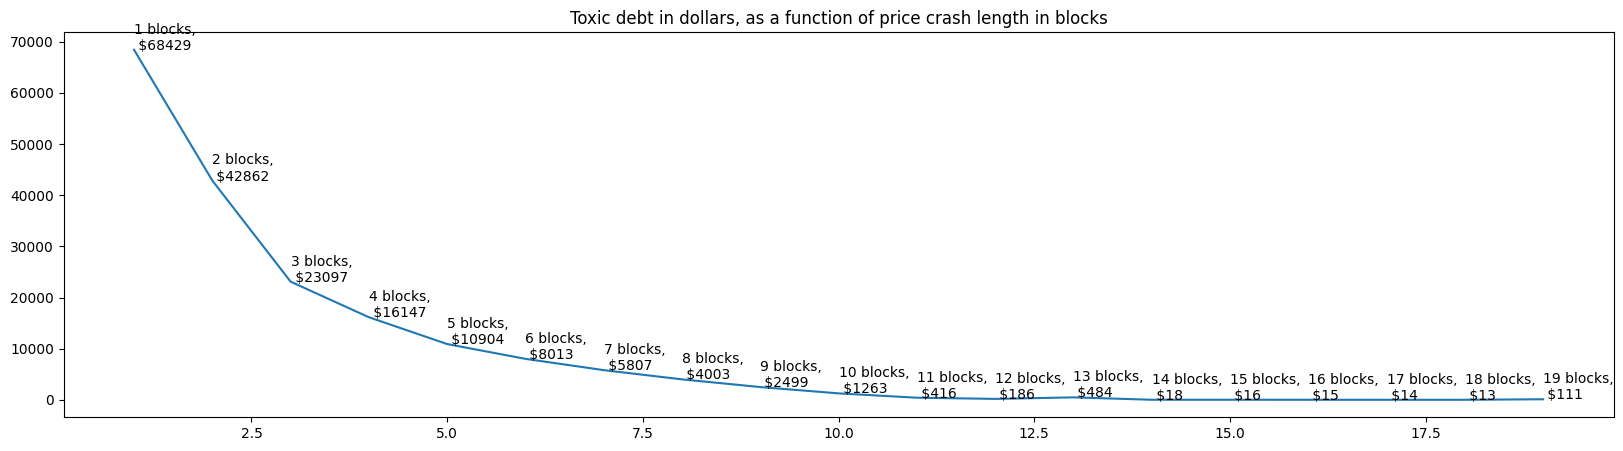

In [54]:
plt.figure(figsize=(20, 5))
plt.plot(run_lengths, toxic_debt)
for i in range(len(run_lengths)):
    plt.annotate(f"{run_lengths[i]} blocks,\n ${round(toxic_debt[i])}", (run_lengths[i], toxic_debt[i]))
plt.title("Toxic debt in dollars, as a function of price crash length in blocks")
plt.show()

In [55]:
hdx_sell_total * omnipool.usd_price('HDX', 'USDT')

841618.1332333051

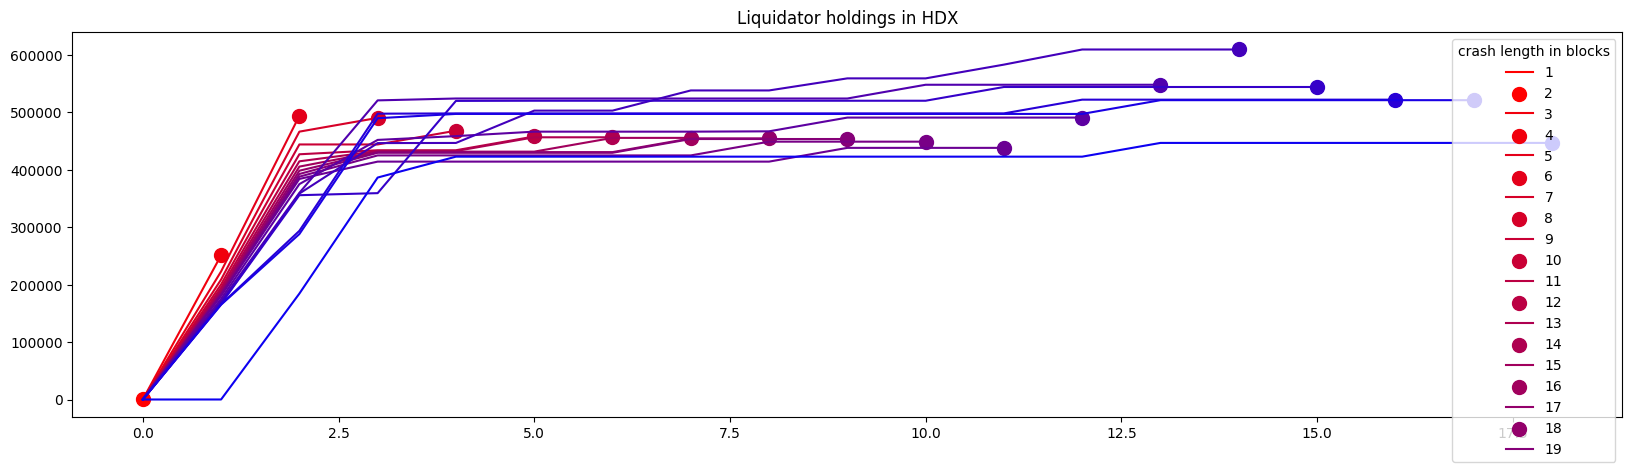

In [56]:
from model import plot_utils as pu
plt.figure(figsize=(20, 5))
colors = pu.color_gradient(len(run_lengths), (255, 0, 0), (0, 0, 255))
for i in range(len(run_lengths)):
    events = runs[i]
    color = colors[i]
    plt.plot([event.agents['liquidator'].holdings['HDX'] for event in events], color)
    plt.scatter(len(events) - 1, events[-1].agents['liquidator'].holdings['HDX'], color=color, s=100)
plt.legend(run_lengths, title='crash length in blocks')
plt.title('Liquidator holdings in HDX')
plt.show()

In [57]:
1 - runs[9][-1].pools['omnipool'].usd_price('HDX', 'USDT') / (omnipool.usd_price('HDX', 'USDT') / 4)

0.11183548078085803

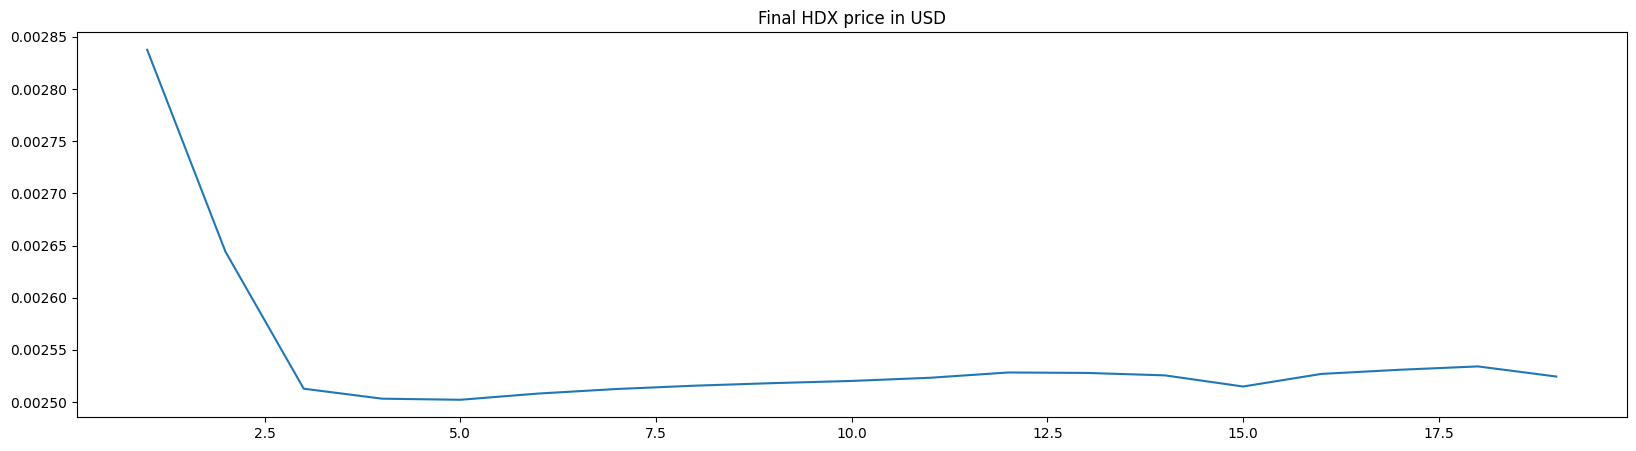

In [58]:
plt.figure(figsize=(20, 5))
plt.plot(run_lengths, [events[-1].pools['omnipool'].usd_price('HDX', 'USDT') for events in runs])
plt.title('Final HDX price in USD')
plt.show()

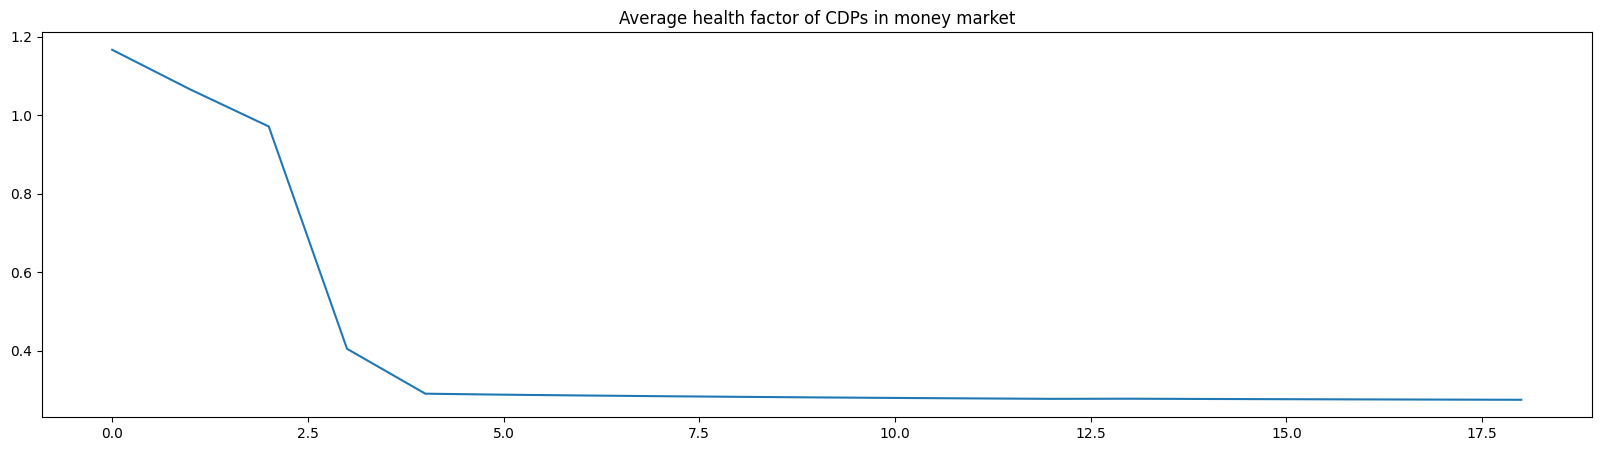

In [59]:
plt.figure(figsize=(20, 5))
plt.plot([sum([event.money_market.get_health_factor(cdp) for cdp in event.money_market.cdps]) / len(event.money_market.cdps) for event in events])
plt.title('Average health factor of CDPs in money market')
plt.show()

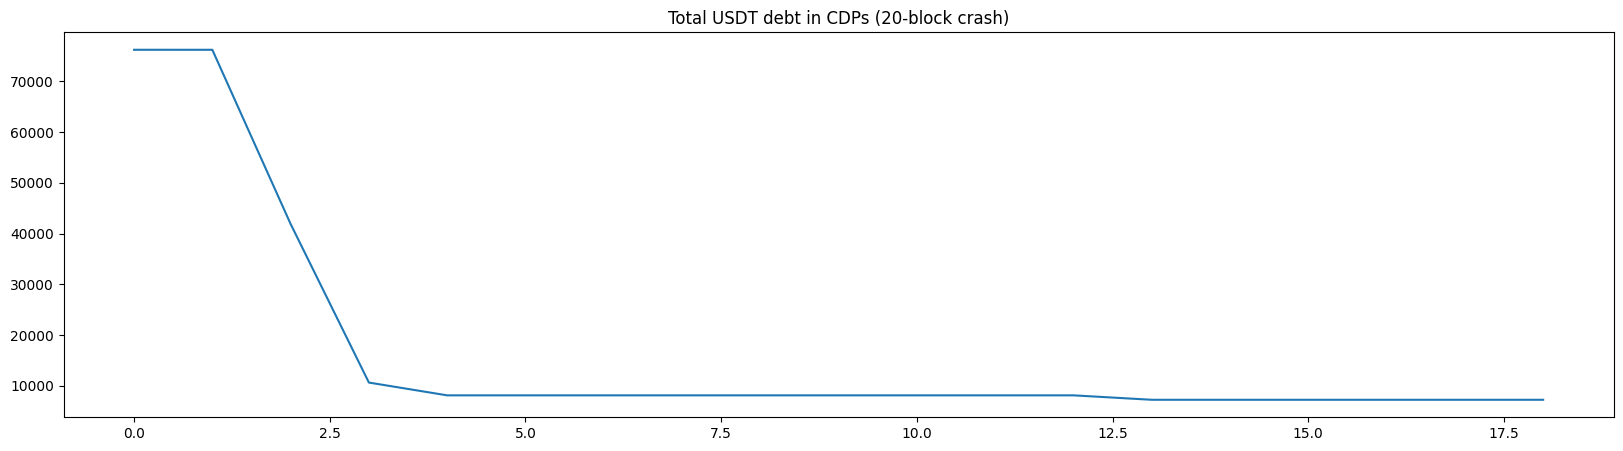

In [60]:
plt.figure(figsize=(20, 5))
liquidated_cdps = [sum([sum(cdp.debt.values()) for cdp in event.money_market.cdps]) for event in runs[-1]]
plt.plot(liquidated_cdps)
plt.title('Total USDT debt in CDPs (20-block crash)')
plt.show()

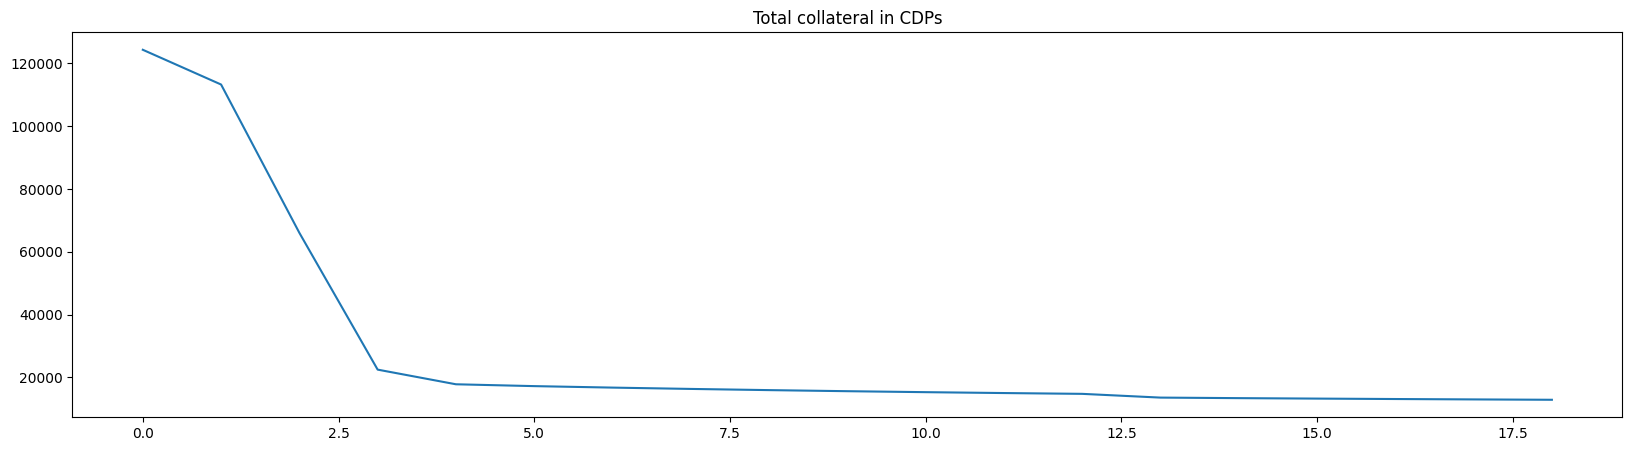

In [61]:
plt.figure(figsize=(20, 5))
liquidated_cdps = [sum([sum([cdp.collateral[c] * event.external_market[c] for c in cdp.collateral]) for cdp in event.money_market.cdps]) for event in events]
plt.plot(liquidated_cdps)
plt.title('Total collateral in CDPs')
plt.show()

In [62]:
print([events[-1].pools['omnipool'].lrna_price('HDX') for events in runs])
print([events[0].pools['omnipool'].lrna_price('HDX') for events in runs])
print(hdx_sell_total)
print(omnipool.liquidity['HDX'])
print(runs[0][-1].pools['omnipool'].lrna_price('HDX') / runs[0][0].pools['omnipool'].lrna_price('HDX'))

[0.00015498497388938425, 0.00014455084104926616, 0.00013746869548508266, 0.00013698518975666926, 0.00013695297558760584, 0.00013729464191881172, 0.00013754338497993016, 0.0001377270258303375, 0.0001378680429867359, 0.00013798835333734917, 0.00013815844574824963, 0.00013843727289529267, 0.00013841203287062558, 0.0001382866761347769, 0.00013770146609904527, 0.00013836368932984452, 0.00013858094446289452, 0.00013875618850580788, 0.0001382254693161711]
[0.00015498497388938425, 0.00027552882795275755, 0.00034871616369100633, 0.00039676149552808973, 0.00043051377099296835, 0.0004554659942916343, 0.00047464142626768677, 0.0004898289930602918, 0.000502151251903118, 0.0005123469548617189, 0.0005209216491781474, 0.0005282327397656743, 0.0005345399395635524, 0.0005400364572612855, 0.0005448689734701991, 0.000549150834353567, 0.0005529710019851942, 0.0005564002707851093, 0.0005594956761470885]
74149461.94812712
74149461.94812712
1.0


In [63]:
toxic_debt = []

for i, event in enumerate(runs[-1]):
    toxic_debt.append([])
    for j, cdp in enumerate(event.money_market.cdps):
        if event.pools['omnipool'].value_assets(cdp.debt, numeraire='USDT') > event.pools['omnipool'].value_assets(cdp.collateral, numeraire='USDT'):
            # bad debt
            toxic_debt[i].append({
                'debt': {
                    'assets': cdp.debt,
                    'value': event.pools['omnipool'].value_assets(cdp.debt, numeraire='USDT')
                },
                'collateral': {
                    'assets': cdp.collateral,
                    'value': event.pools['omnipool'].value_assets(cdp.collateral, numeraire='USDT')
                },
                'index': j
            })

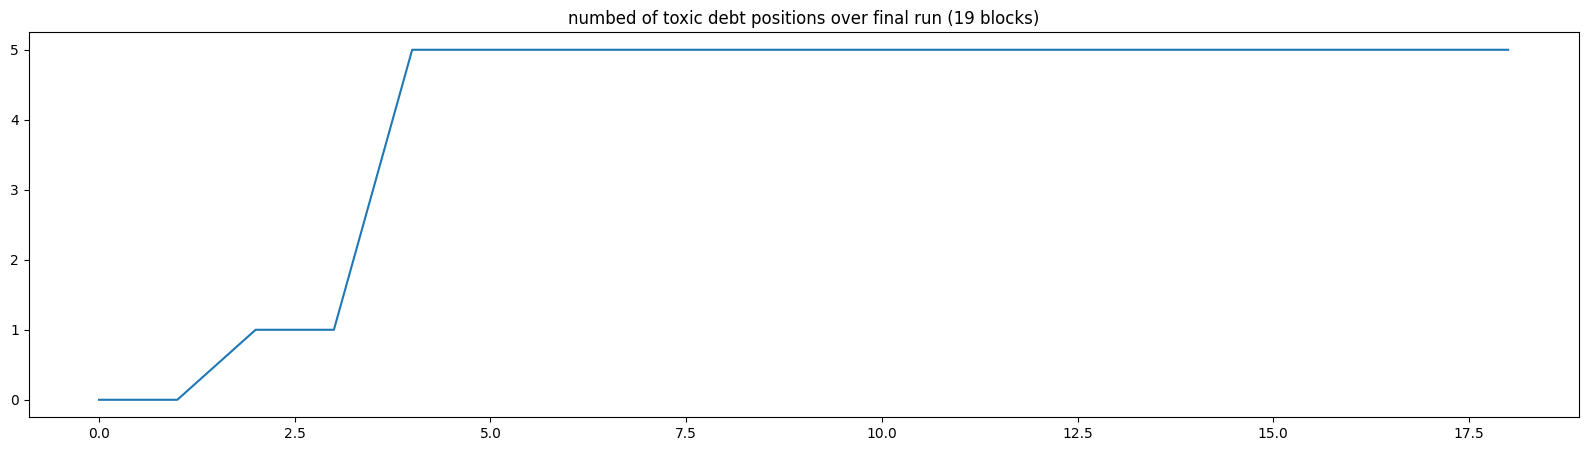

In [67]:
plt.figure(figsize=(20, 5))
plt.plot([len(step) for step in toxic_debt])
plt.title(f"numbed of toxic debt positions over final run ({len(toxic_debt)} blocks)")
plt.show()

In [68]:
for cdp in toxic_debt[-1]:
    print(f"  index: {cdp['index']}")
    print(f"    debt: {cdp['debt']}")
    print(f"    collateral: {cdp['collateral']}")

  index: 22
    debt: {'assets': {'USDT': 21.74455822106937}, 'value': 21.74455822106937}
    collateral: {'assets': {'HDX': 0.0, 'USDT': 4.588366250432303e-06}, 'value': 4.588366250432303e-06}
  index: 42
    debt: {'assets': {'USDT': 47.700373045771016}, 'value': 47.700373045771016}
    collateral: {'assets': {'HDX': 0.0}, 'value': 0.0}
  index: 43
    debt: {'assets': {'USDT': 39.326006902186805}, 'value': 39.326006902186805}
    collateral: {'assets': {'HDX': 0.0}, 'value': 0.0}
  index: 47
    debt: {'assets': {'USDT': 1.507017311307166}, 'value': 1.507017311307166}
    collateral: {'assets': {'HDX': 0.0}, 'value': 0.0}
  index: 48
    debt: {'assets': {'USDT': 0.8871727839093992}, 'value': 0.8871727839093992}
    collateral: {'assets': {'HDX': 0.0}, 'value': 0.0}


In [ ]:
for i in [cdp['index'] for cdp in toxic_debt[-1]]:
    print(hdx_cdps[i])
    print('    value:')
    for tkn in hdx_cdps[i].collateral:
        print(f"{tkn}: {mm.value_assets({tkn: hdx_cdps[i].collateral[tkn]})}")

In [ ]:
omnipool_router.exchanges